## Problem Statement:
* Create a Machine learning application which predicts the estimated time and date for the final closure of a opened ticket based on the given attributes.

## Dataset Information:
* This is an event log of an incident management process extracted from data gathered from the audit system of a platform used by an IT company. Information was anonymized for privacy.

* Number of instances: 141,712 events (24,918 incidents) /Each even corresponds to an update that is made to the incident.
* Number of attributes: 36 attributes.

## Steps:
* Data is cleaned by replacing all the missing values with 'unknown'.
* For this project I have kept only the incidents that are already closed.
* Some incidents are removed by using outlier identification methods using z scores.
* I have kept only those features that are available at the begining of the incident creation. The idea is to use only the information available to us at the time of incident creation and predict the closure time of the incident.
* I have treated this problem as a regression problem. I have taken minimum opened time as a fixed time stamp from opened_at feature of the incident and converted opened_at and closed_at as time differences in seconds.
* The target is to predict the time of completion as seconds and add them to the fixed time stamp to get exatc date and time of ticket closure.

## Inputs:
* Some of the inputs that are used are:
    - caller_id: identifier of the user affected;
    - opened_by: identifier of the user who reported the incident;
    - opened_at: incident user opening date and time;
    - sys_created_by: identifier of the user who registered the incident;
    - contact_type: categorical attribute that shows by what means the incident was reported;
    - location: identifier of the location of the place affected;
    - category: first-level description of the affected service;
    - subcategory: second-level description of the affected service (related to the first level description, i.e., to category);
    - u_symptom: description of the user perception about service availability;
    - impact: description of the impact caused by the incident (values: High; Medium; Low);
    - urgency: description of the urgency informed by the user for the incident resolution (values: High; Medium; Low);
    - priority: calculated by the system based on 'impact' and 'urgency';
    - assignment_group: identifier of the support group in charge of the incident;
    - assigned_to: identifier of the user in charge of the incident;
    - knowledge: boolean attribute that shows whether a knowledge base document was used to resolve the incident;
    - u_priority_confirmation: boolean attribute that shows whether the priority field has been double-checked;
    - notify: categorical attribute that shows whether notifications were generated for the incident;

In [252]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from warnings import filterwarnings
filterwarnings(action='ignore')

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error

In [499]:
def get_uniques(df):
    feature = []
    uniques = []
    percent_uniques = []
    dtype = []
    cols = df.columns.values
    for col in cols:
        feature.append(col)
        uniques.append(df[col].nunique())
        percent_uniques.append((df[col].nunique()/df.shape[0])*100)
        dtype.append(df[col].dtype)

    uniques_df = pd.DataFrame({'feature':feature,'uniques':uniques,'percent_uniques':percent_uniques,'dtype':dtype})
    return uniques_df

def sec_to_days(sec,time_stamp=False):
    day = sec // (24 * 3600)
    sec = sec % (24 * 3600)
    hour = sec // 3600
    sec %= 3600
    minutes = sec // 60
    sec %= 60
    seconds = round(sec,2)
    if time_stamp:
        return min_date+timedelta(days=day,hours=hour,minutes=minutes,seconds=seconds)
    else:
        return [day, hour, minutes, seconds]

def get_outliers_Zscore(data,threshold = 3, boxplot = False):
    outliers_index = []
    outliers_values = []
    Mean = np.mean(data)
    Std =np.std(data)
    
    for i, value in data.iteritems():
        z_score= (value - Mean)/Std 
        if np.abs(z_score) > threshold:
            outliers_index.append(i)
            outliers_values.append(value)
    if boxplot == True:
        plt.boxplot(data.dropna())
    return pd.DataFrame({'outliers_index':outliers_index,'outliers_values':outliers_values})

In [465]:
data = pd.read_csv('Data/incident_event_log_train.csv')

In [466]:
data.shape

(119998, 36)

In [467]:
data.replace('?','unknown',inplace=True)

In [574]:
closed_incidents = data[(data.incident_state == 'Closed')&(data.reopen_count == 0)].copy()

In [575]:
closed_incidents['opened_at_date_time'] = pd.to_datetime(closed_incidents['opened_at'],dayfirst=True,format='%d/%m/%Y %H:%M')
closed_incidents['closed_at_date_time'] = pd.to_datetime(closed_incidents['closed_at'],dayfirst=True,format='%d/%m/%Y %H:%M')

In [576]:
min_date = closed_incidents.opened_at_date_time.min()

In [577]:
closed_incidents['opened_at_days'] = (closed_incidents.opened_at_date_time - min_date)
closed_incidents['closed_at_days'] = (closed_incidents.closed_at_date_time - min_date)

In [578]:
closed_incidents['opened_at_seconds'] = closed_incidents['opened_at_days'].apply(lambda x: x.total_seconds())
closed_incidents['closed_at_seconds'] = closed_incidents['closed_at_days'].apply(lambda x: x.total_seconds())

In [579]:
closed_incidents['time_of_completion'] = closed_incidents['closed_at_seconds'] - closed_incidents['opened_at_seconds']

In [580]:
closed_incidents[closed_incidents['time_of_completion']<0]

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,resolved_by,resolved_at,closed_at,opened_at_date_time,closed_at_date_time,opened_at_days,closed_at_days,opened_at_seconds,closed_at_seconds,time_of_completion


In [581]:
actual_closed_dates = closed_incidents[["closed_at_date_time","opened_at_date_time"]]

In [582]:
closed_incidents.drop(['sys_created_at','cmdb_ci','problem_id','rfc','vendor','caused_by','resolved_at','closed_at','opened_at','opened_at_date_time','opened_at_date_time','closed_at_date_time','number','closed_at_days','closed_at_seconds','opened_at_days','incident_state','active','reopen_count','made_sla','closed_code','resolved_by'],axis=1,inplace=True)

In [583]:
outliers_ids = get_outliers_Zscore(closed_incidents.time_of_completion).outliers_index.values
closed_incidents.drop(outliers_ids,axis=0,inplace=True)

In [584]:
object_cols = []
for col in closed_incidents.columns:
    if (closed_incidents[col].dtype == 'object') or (closed_incidents[col].dtype == 'bool'):
        object_cols.append(col) 

In [585]:
le = LabelEncoder()

In [586]:
for col in object_cols:
    closed_incidents[col] = le.fit_transform(closed_incidents[col])

In [587]:
X = closed_incidents.drop(['time_of_completion'],axis=1)
y = closed_incidents.time_of_completion

In [588]:
cat_cols = ["contact_type","impact","urgency","priority","knowledge","u_priority_confirmation","notify"]

In [589]:
num_cols = list(set(X.columns.values) - set(cat_cols))

In [590]:
sscaler = StandardScaler()

In [591]:
X[num_cols] = sscaler.fit_transform(X[num_cols])

In [592]:
X[cat_cols] = X[cat_cols].astype('object')

In [593]:
X = pd.get_dummies(X)

In [594]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size=0.7)

In [595]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(14149, 32)
(6065, 32)
(14149,)
(6065,)


In [596]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train,y_train)

y_train_predict = xgb_model.predict(X_train)
y_valid_predict = xgb_model.predict(X_valid)


print(('Train predictions are off by {} D: {} H: {} M: {} S').format(sec_to_days(mean_absolute_error(y_train_predict,y_train))[0],
                                                                    sec_to_days(mean_absolute_error(y_train_predict,y_train))[1],
                                                                    sec_to_days(mean_absolute_error(y_train_predict,y_train))[2],
                                                                    sec_to_days(mean_absolute_error(y_train_predict,y_train))[3]))
print(('Valid predictions are off by {} D: {} H: {} M: {} S').format(sec_to_days(mean_absolute_error(y_valid_predict,y_valid))[0],
                                                                    sec_to_days(mean_absolute_error(y_valid_predict,y_valid))[1],
                                                                    sec_to_days(mean_absolute_error(y_valid_predict,y_valid))[2],
                                                                    sec_to_days(mean_absolute_error(y_valid_predict,y_valid))[3]))

[19:48:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train predictions are off by 2.0 D: 3.0 H: 0.0 M: 33.33 S
Valid predictions are off by 2.0 D: 6.0 H: 7.0 M: 43.99 S


In [597]:
xgb_model = XGBRegressor(max_depth= 8,n_estimators=200)
xgb_model.fit(X_train,y_train)

y_train_predict = xgb_model.predict(X_train)
y_valid_predict = xgb_model.predict(X_valid)


print(('Train predictions are off by {} D: {} H: {} M: {} S').format(sec_to_days(mean_absolute_error(y_train_predict,y_train))[0],
                                                                    sec_to_days(mean_absolute_error(y_train_predict,y_train))[1],
                                                                    sec_to_days(mean_absolute_error(y_train_predict,y_train))[2],
                                                                    sec_to_days(mean_absolute_error(y_train_predict,y_train))[3]))
print(('Valid predictions are off by {} D: {} H: {} M: {} S').format(sec_to_days(mean_absolute_error(y_valid_predict,y_valid))[0],
                                                                    sec_to_days(mean_absolute_error(y_valid_predict,y_valid))[1],
                                                                    sec_to_days(mean_absolute_error(y_valid_predict,y_valid))[2],
                                                                    sec_to_days(mean_absolute_error(y_valid_predict,y_valid))[3]))

[19:49:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train predictions are off by 0.0 D: 7.0 H: 3.0 M: 27.18 S
Valid predictions are off by 1.0 D: 5.0 H: 18.0 M: 22.78 S


In [630]:
train_closed = pd.DataFrame({'actual_seconds':y_train,'predicted_seconds':y_train_predict})
valid_closed = pd.DataFrame({'actual_seconds':y_valid,'Predicted_seconds':y_valid_predict})

In [631]:
train_closed = train_closed.merge(actual_closed_dates,how='left',left_index=True,right_index=True)
valid_closed = valid_closed.merge(actual_closed_dates,how='left',left_index=True,right_index=True)

In [632]:
train_closed['actual_opened_days'] = train_closed.opened_at_date_time - min_date
valid_closed['actual_opened_days'] = valid_closed.opened_at_date_time - min_date

In [633]:
train_closed['predicted_close_date'] = train_closed.apply(lambda x: sec_to_days(x.predicted_seconds,time_stamp=True)+x.actual_opened_days,axis=1)
valid_closed['predicted_close_date'] = valid_closed.apply(lambda x: sec_to_days(x.Predicted_seconds,time_stamp=True)+x.actual_opened_days,axis=1)

In [634]:
train_closed['diff_in_prediction'] = train_closed.predicted_close_date - train_closed.closed_at_date_time
valid_closed['diff_in_prediction'] = valid_closed.predicted_close_date - valid_closed.closed_at_date_time

In [635]:
train_closed.drop(['actual_opened_days'],axis=1,inplace=True)
valid_closed.drop(['actual_opened_days'],axis=1,inplace=True)

train_closed.rename({'closed_at_date_time':'actual_close_date'},inplace=True,axis=1)
valid_closed.rename({'closed_at_date_time':'actual_close_date'},inplace=True,axis=1)

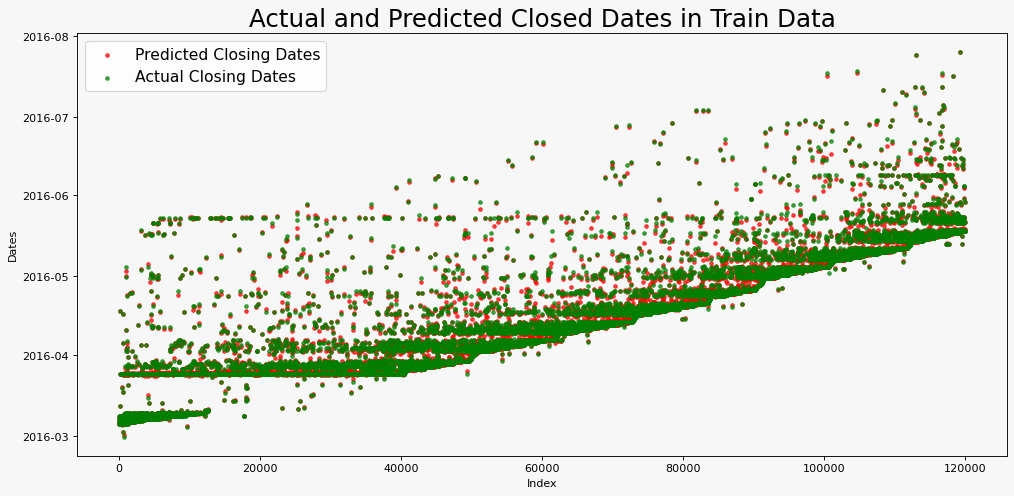

In [636]:
fig, ax = plt.subplots(1,1,figsize=(15,7), dpi= 80, facecolor='#f7f7f7')

# Points
ax.scatter(x=train_closed.index.values, y=train_closed.predicted_close_date, s=10, color='r', alpha=0.7,label='Predicted Closing Dates')
ax.scatter(x=train_closed.index.values, y=train_closed.actual_close_date, s=10, color='g', alpha=0.7,label='Actual Closing Dates')

# Decoration
ax.set_facecolor('#f7f7f7')
ax.set_title("Actual and Predicted Closed Dates in Train Data", fontdict={'size':22})
ax.set(xlabel='Index',ylabel='Dates')
ax.legend(fontsize=14)
plt.show()

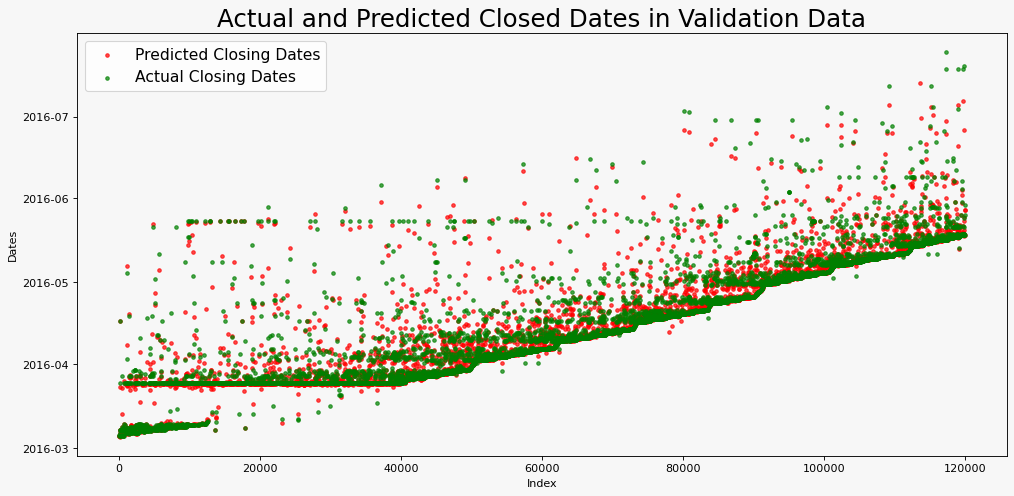

In [637]:
fig, ax = plt.subplots(1,1,figsize=(15,7), dpi= 80, facecolor='#f7f7f7')

# Points
ax.scatter(x=valid_closed.index.values, y=valid_closed.predicted_close_date, s=10, color='r', alpha=0.7,label='Predicted Closing Dates')
ax.scatter(x=valid_closed.index.values, y=valid_closed.actual_close_date, s=10, color='g', alpha=0.7,label='Actual Closing Dates')

# Decoration
ax.set_facecolor('#f7f7f7')
ax.set_title("Actual and Predicted Closed Dates in Validation Data", fontdict={'size':22})
ax.set(xlabel='Index',ylabel='Dates')
ax.legend(fontsize=14)
plt.show()

In [638]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_closed.index.values, y=train_closed.actual_close_date,
                    mode='markers', name='Actual Dates'))
fig.add_trace(go.Scatter(x=train_closed.index.values, y=train_closed.predicted_close_date,
                    mode='markers', name='Predicted Dates'))
fig.update_layout(title='Actual and Predicted Closed Dates in Train Data',
                   xaxis_title='Index',
                   yaxis_title='Date')
fig.show()

In [639]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=valid_closed.index.values, y=valid_closed.actual_close_date,
                    mode='markers', name='Actual Dates'))
fig.add_trace(go.Scatter(x=valid_closed.index.values, y=valid_closed.predicted_close_date,
                    mode='markers', name='Predicted Dates'))
fig.update_layout(title='Actual and Predicted Closed Dates in Validation Data',
                   xaxis_title='Index',
                   yaxis_title='Date')
fig.show()